In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # 🔹 Ajoutez cette ligne pour éviter l'erreur NameError
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import requests
import os


In [15]:


# Définition de l'URL de la base de données ETTh1
DATA_URL = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
DATA_PATH = "ETTh1.csv"

# Télécharger le fichier si ce n'est pas déjà fait
if not os.path.exists(DATA_PATH):
    response = requests.get(DATA_URL)
    with open(DATA_PATH, "wb") as file:
        file.write(response.content)

# Charger les données
df = pd.read_csv(DATA_PATH)

# Afficher les premières lignes
print(df.head())

# Conversion de la colonne 'date' en datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Normalisation des données (Min-Max scaling)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Création de séquences temporelles pour le modèle
def create_sequences(data, seq_length):
    """
    Crée des séquences pour le modèle.
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 24  # Ex: 24 heures d'historique pour prédire la prochaine valeur
X, y = create_sequences(df_scaled.values, SEQ_LENGTH)

# Conversion en tenseurs PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Création du dataset PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Création des DataLoaders
dataset = TimeSeriesDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Taille du dataset d'entraînement: {len(train_dataset)}")
print(f"Taille du dataset de test: {len(test_dataset)}")


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Taille du dataset d'entraînement: 13916
Taille du dataset de test: 3480


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# MLP classique
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# FANLayer intégré dans un MLP
class FANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, p_ratio=0.25, activation='gelu', use_p_bias=True):
        super(FANLayer, self).__init__()
        
        assert 0 < p_ratio < 0.5, "p_ratio doit être entre 0 et 0.5"
        self.p_ratio = p_ratio
        p_output_dim = int(output_dim * self.p_ratio)
        g_output_dim = output_dim - (p_output_dim * 2)

        self.input_linear_p = nn.Linear(input_dim, p_output_dim, bias=use_p_bias)
        self.input_linear_g = nn.Linear(input_dim, g_output_dim)

        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = activation if activation else lambda x: x

    def forward(self, src):
        g = self.activation(self.input_linear_g(src))
        p = self.input_linear_p(src)
        output = torch.cat((torch.cos(p), torch.sin(p), g), dim=-1)
        return output
    



# Modèle avec FANLayer
class FAN_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FAN_MLP, self).__init__()
        self.fan = FANLayer(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.fan(x)
        x = self.activation(self.fc(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x
    

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Modification de la fonction d'entraînement pour stocker la loss
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    model.train()
    
    train_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            outputs = outputs[:, -1, :]  # Prend uniquement la dernière valeur temporelle


            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    
    return train_losses

# Modification de la fonction d'évaluation pour stocker la loss
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            outputs = outputs[:, -1, :]  # Prend uniquement la dernière valeur temporelle

            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.6f}")
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    return avg_loss, all_preds, all_targets


In [34]:
# Définition des dimensions des entrées et des sorties
input_dim = X_tensor.shape[2]  # Nombre de features (variables d'entrée)
hidden_dim = 128  # Nombre de neurones dans la couche cachée
output_dim = y_tensor.shape[1]  # Nombre de sorties (variable cible)
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Initialisation des modèles
mlp_model = MLP(input_dim, hidden_dim, output_dim).to(device)
fan_mlp_model = FAN_MLP(input_dim, hidden_dim, output_dim).to(device)


# Définition des optimisateurs
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
fan_mlp_optimizer = optim.Adam(fan_mlp_model.parameters(), lr=0.001)

# Entraînement et évaluation du MLP classique
print("\n🔹 Entraînement du MLP classique")
mlp_train_losses = train_model(mlp_model, train_loader, nn.MSELoss(), mlp_optimizer, device, epochs)
mlp_test_loss, mlp_preds, mlp_targets = evaluate_model(mlp_model, test_loader, nn.MSELoss(), device)

# Entraînement et évaluation du FAN MLP
print("\n🔹 Entraînement du FAN MLP")
fan_mlp_train_losses = train_model(fan_mlp_model, train_loader, nn.MSELoss(), fan_mlp_optimizer, device, epochs)
fan_mlp_test_loss, fan_preds, fan_targets = evaluate_model(fan_mlp_model, test_loader, nn.MSELoss(), device)



🔹 Entraînement du MLP classique
Epoch [1/20], Loss: 0.007972
Epoch [2/20], Loss: 0.002747
Epoch [3/20], Loss: 0.002719
Epoch [4/20], Loss: 0.002696
Epoch [5/20], Loss: 0.002707
Epoch [6/20], Loss: 0.002708
Epoch [7/20], Loss: 0.002693
Epoch [8/20], Loss: 0.002709
Epoch [9/20], Loss: 0.002681
Epoch [10/20], Loss: 0.002677
Epoch [11/20], Loss: 0.002675
Epoch [12/20], Loss: 0.002662
Epoch [13/20], Loss: 0.002656
Epoch [14/20], Loss: 0.002659
Epoch [15/20], Loss: 0.002656
Epoch [16/20], Loss: 0.002649


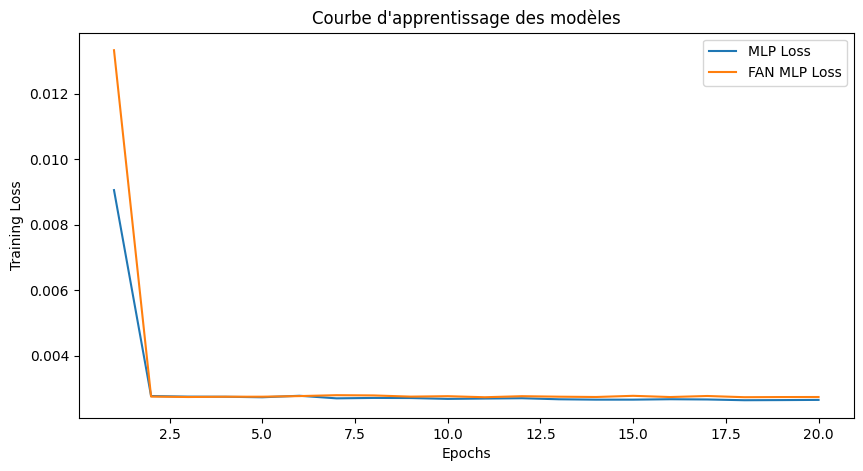

In [29]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), mlp_train_losses, label="MLP Loss")
plt.plot(range(1, epochs+1), fan_mlp_train_losses, label="FAN MLP Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Courbe d'apprentissage des modèles")
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcul des métriques pour le MLP
mlp_mae = mean_absolute_error(mlp_targets, mlp_preds)
mlp_rmse = np.sqrt(mean_squared_error(mlp_targets, mlp_preds))

# Calcul des métriques pour le FAN MLP
fan_mae = mean_absolute_error(fan_targets, fan_preds)
fan_rmse = np.sqrt(mean_squared_error(fan_targets, fan_preds))

# Affichage des résultats
print("\n📊 Comparaison des performances sur le test set")
print(f"MLP - MSE: {mlp_test_loss:.6f}, MAE: {mlp_mae:.6f}, RMSE: {mlp_rmse:.6f}")
print(f"FAN MLP - MSE: {fan_mlp_test_loss:.6f}, MAE: {fan_mae:.6f}, RMSE: {fan_rmse:.6f}")



📊 Comparaison des performances sur le test set
MLP - MSE: 0.002559, MAE: 0.034117, RMSE: 0.050576
FAN MLP - MSE: 0.002603, MAE: 0.034160, RMSE: 0.051007


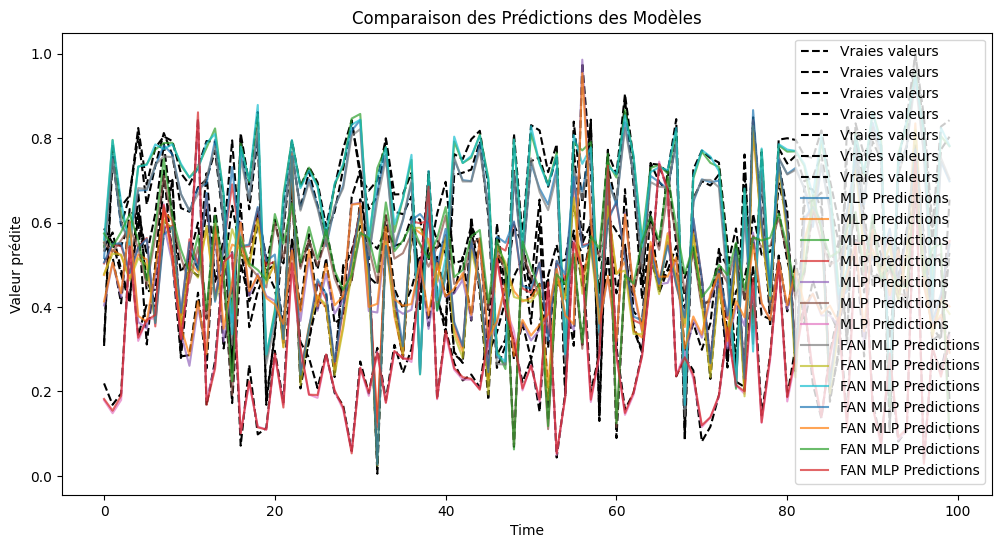

In [31]:
plt.figure(figsize=(12,6))

# Sélection d'un sous-ensemble de données (par ex. les 100 premières valeurs)
plot_range = 100

plt.plot(fan_targets[:plot_range], label="Vraies valeurs", color="black", linestyle="dashed")
plt.plot(mlp_preds[:plot_range], label="MLP Predictions", alpha=0.7)
plt.plot(fan_preds[:plot_range], label="FAN MLP Predictions", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Valeur prédite")
plt.title("Comparaison des Prédictions des Modèles")
plt.legend()
plt.show()
